In [1]:
# Import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import seaborn as sns
import re
import statistics

%matplotlib inline 

# Some Notes regarding this data(census)

* I have included the data file layout in my data folder, so some of this is just repeated from there.
* The estimates are based on the 2010 Census and were created without incorporation or consideration of the 2020 Census results. 
* All geographic boundaries for these population estimates are as of January 1, 2020.
* An "A" in the 2010 Census field indicates a government that was formed or incorporated after the 2010 Census. 


In [2]:
og_df = pd.read_csv('../data/census/city_pop_est_2010_2020.csv')
city_pop = og_df

In [3]:
og_df.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
0,40,1,0,0,0,0,0,A,Alabama,Alabama,...,4799642,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4921532
1,162,1,0,124,0,0,0,A,Abbeville city,Alabama,...,2694,2645,2629,2610,2602,2587,2578,2565,2555,2553
2,162,1,0,460,0,0,0,A,Adamsville city,Alabama,...,4474,4453,4430,4399,4371,4335,4304,4285,4254,4211
3,162,1,0,484,0,0,0,A,Addison town,Alabama,...,750,745,744,742,734,734,728,725,723,717
4,162,1,0,676,0,0,0,A,Akron town,Alabama,...,347,347,344,338,338,335,332,332,328,327


In [4]:
# 'SUMLEV' code 40 will show the pop at a state level
state_pop = og_df[og_df['SUMLEV'] == 40]

In [5]:
state_pop.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
0,40,1,0,0,0,0,0,A,Alabama,Alabama,...,4799642,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4921532
1109,40,2,0,0,0,0,0,A,Alaska,Alaska,...,722349,730810,737626,737075,738430,742575,740983,736624,733603,731158
1459,40,4,0,0,0,0,0,A,Arizona,Arizona,...,6473416,6556344,6634690,6732873,6832810,6944767,7048088,7164228,7291843,7421401
1680,40,5,0,0,0,0,0,A,Arkansas,Arkansas,...,2941038,2952876,2960459,2968759,2979732,2991815,3003855,3012161,3020985,3030522
2853,40,6,0,0,0,0,0,A,California,California,...,37636311,37944551,38253768,38586706,38904296,39149186,39337785,39437463,39437610,39368078


# Time to explore some of this data
\
I want to start with Nashville's population and find cities with similar sizes. \
+- 10% of Nashville's pop should be good for cities within similar size

In [6]:
city_pop['SUMLEV'].value_counts()

157    23705
61     21062
162    19494
71     13837
50      3143
172      115
40        51
170        8
Name: SUMLEV, dtype: int64

In [7]:
'''
I will be using 'SUMLEV' 162 because that is the instance that specifies that entry is an 'incorporated place'

The census defines an 'incorporated place' as:
    "An incorporated place, under the Census Bureau's definition,[2] is a type of governmental unit incorporated under state law as a city, town (except the New England states, New York, and Wisconsin),[3] borough (except in Alaska and New York),
    [4] or village, and having legally prescribed limits, powers, and functions".
'''

city_pop = city_pop[city_pop['SUMLEV'] == 162]

In [8]:
# Dropping some unnecessary columns
city_pop = city_pop.drop(columns=['SUMLEV','STATE', 'COUNTY', 'PLACE', 'COUSUB', 'CONCIT', 'PRIMGEO_FLAG', 'FUNCSTAT'])

# Renaming some columns
city_pop = city_pop.rename(columns={"NAME": "CITY", "STNAME": "STATE"})

In [37]:
# A little bit of cleaning for use later.

city_pop['CITY'] = city_pop['CITY'].str.replace('city','')
city_pop.loc[(city_pop.CITY == 'Louisville/Jefferson County metro government (balance)'),'CITY']='Louisville'
city_pop.loc[(city_pop.CITY == 'Nashville-Davidson metropolitan government (balance)'),'CITY']='Nashville'
city_pop

,CITY,STATE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
1,Abbeville,Alabama,2688,2705,2699,2694,2645,2629,2610,2602,2587,2578,2565,2555,2553
2,Adamsville,Alabama,4522,4487,4481,4474,4453,4430,4399,4371,4335,4304,4285,4254,4211
3,Addison town,Alabama,758,754,751,750,745,744,742,734,734,728,725,723,717
4,Akron town,Alabama,356,356,355,347,347,344,338,338,335,332,332,328,327
5,Alabaster,Alabama,30352,31095,31192,31361,31673,31969,32177,32767,33040,33291,33442,33522,33701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81264,Wamsutter town,Wyoming,451,451,450,452,463,488,509,502,494,485,478,471,467
81265,Wheatland town,Wyoming,3627,3629,3626,3623,3628,3625,3645,3647,3592,3556,3548,3494,3522
81266,Worland,Wyoming,5487,5487,5488,5437,5419,5423,5331,5336,5273,5160,5077,5037,4994
81267,Wright town,Wyoming,1807,1807,1810,1813,1863,1860,1856,1886,1862,1760,1754,1751,1758


In [9]:
# Filtering by 2 criteria, trying to narrow down Nashville down to those within TN
# df loc - locate within this df the following: under the 'NAME' column, find all strings that contain 'Nashville'. Under the 'STNAME' column, limit it TN
nash_pop = city_pop.loc[(city_pop['CITY'].str.contains("Nashville")) & (city_pop['STATE']=='Tennessee')]

In [10]:
nash_pop

,CITY,STATE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,601222,603465,604644,612689,625824,636375,645741,656089,662344,664220,667772,669725,671295


In [11]:
city_2020_pop = city_pop[['CITY', 'STATE', 'POPESTIMATE2020']]
city_2020_pop

,CITY,STATE,POPESTIMATE2020
1,Abbeville city,Alabama,2553
2,Adamsville city,Alabama,4211
3,Addison town,Alabama,717
4,Akron town,Alabama,327
5,Alabaster city,Alabama,33701
...,...,...,...
81264,Wamsutter town,Wyoming,467
81265,Wheatland town,Wyoming,3522
81266,Worland city,Wyoming,4994
81267,Wright town,Wyoming,1758


In [12]:
# Nash 2020 Pop Estimate
nash_2020_pop = nash_pop[['CITY', 'STATE', 'POPESTIMATE2020']]
nash_2020_pop

,CITY,STATE,POPESTIMATE2020
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,671295


In [13]:
# let's look at cities similar to Nash in terms of pop. I will use 10% (plus or minus) Nash Pop

upper_2020 = 671295*1.1
lower_2020 = 671295*0.9
nash_2020_pop

,CITY,STATE,POPESTIMATE2020
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,671295


In [14]:
similar_size_cities = city_2020_pop[((city_2020_pop['POPESTIMATE2020'] <= upper_2020) & (city_2020_pop['POPESTIMATE2020'] >= lower_2020))]
similar_size_cities

,CITY,STATE,POPESTIMATE2020
3996,Denver city,Colorado,735538
5034,Washington city,District of Columbia,712816
25634,Louisville/Jefferson County metro government (...,Kentucky,618338
28330,Boston city,Massachusetts,691531
28996,Detroit city,Michigan,665369
43978,Las Vegas city,Nevada,662368
59874,Oklahoma City city,Oklahoma,662314
61026,Portland city,Oregon,656751
70434,Memphis city,Tennessee,649705
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,671295


In [15]:
# Let's clean this a bit

similar_size_cities['CITY'] = similar_size_cities['CITY'].str.replace('city','')
similar_size_cities.loc[(similar_size_cities.CITY == 'Louisville/Jefferson County metro government (balance)'),'CITY']='Louisville'
similar_size_cities.loc[(similar_size_cities.CITY == 'Nashville-Davidson metropolitan government (balance)'),'CITY']='Nashville'
similar_size_cities

<ipython-input-15-b5d0a5221c30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_size_cities['CITY'] = similar_size_cities['CITY'].str.replace('city','')
C:\Users\tye64\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,CITY,STATE,POPESTIMATE2020
3996,Denver,Colorado,735538
5034,Washington,District of Columbia,712816
25634,Louisville,Kentucky,618338
28330,Boston,Massachusetts,691531
28996,Detroit,Michigan,665369
43978,Las Vegas,Nevada,662368
59874,Oklahoma City,Oklahoma,662314
61026,Portland,Oregon,656751
70434,Memphis,Tennessee,649705
70455,Nashville,Tennessee,671295


In [16]:
# Gonna save this to a csv to use on my other notebook.

# similar_size_cities.to_csv(r'../data/census/similar_size_cities.csv', index = False)

In [17]:
nash_pop

,CITY,STATE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
70455,Nashville-Davidson metropolitan government (ba...,Tennessee,601222,603465,604644,612689,625824,636375,645741,656089,662344,664220,667772,669725,671295


In [18]:
# I want to do a quick visualization for Nash pop over the years. 

k = nash_pop.drop(columns = ['CITY', 'STATE', 'CENSUS2010POP', 'ESTIMATESBASE2010'])
transpose = k.T.reset_index()

In [19]:
transpose

,index,70455
0,POPESTIMATE2010,604644
1,POPESTIMATE2011,612689
2,POPESTIMATE2012,625824
3,POPESTIMATE2013,636375
4,POPESTIMATE2014,645741
5,POPESTIMATE2015,656089
6,POPESTIMATE2016,662344
7,POPESTIMATE2017,664220
8,POPESTIMATE2018,667772
9,POPESTIMATE2019,669725


In [20]:
# Let's clean this up

transpose = transpose.rename(columns={"index": "Year", 70455: "Estimated_Pop"})
transpose['Year'] = transpose.Year.str.replace('POPESTIMATE','')

In [21]:
transpose['Estimated_Pop'] = transpose['Estimated_Pop'].astype(int)
print(transpose.info())
transpose

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           11 non-null     object
 1   Estimated_Pop  11 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 260.0+ bytes
None


,Year,Estimated_Pop
0,2010,604644
1,2011,612689
2,2012,625824
3,2013,636375
4,2014,645741
5,2015,656089
6,2016,662344
7,2017,664220
8,2018,667772
9,2019,669725


Text(0.5, 1.0, 'Nashville Estimate Population')

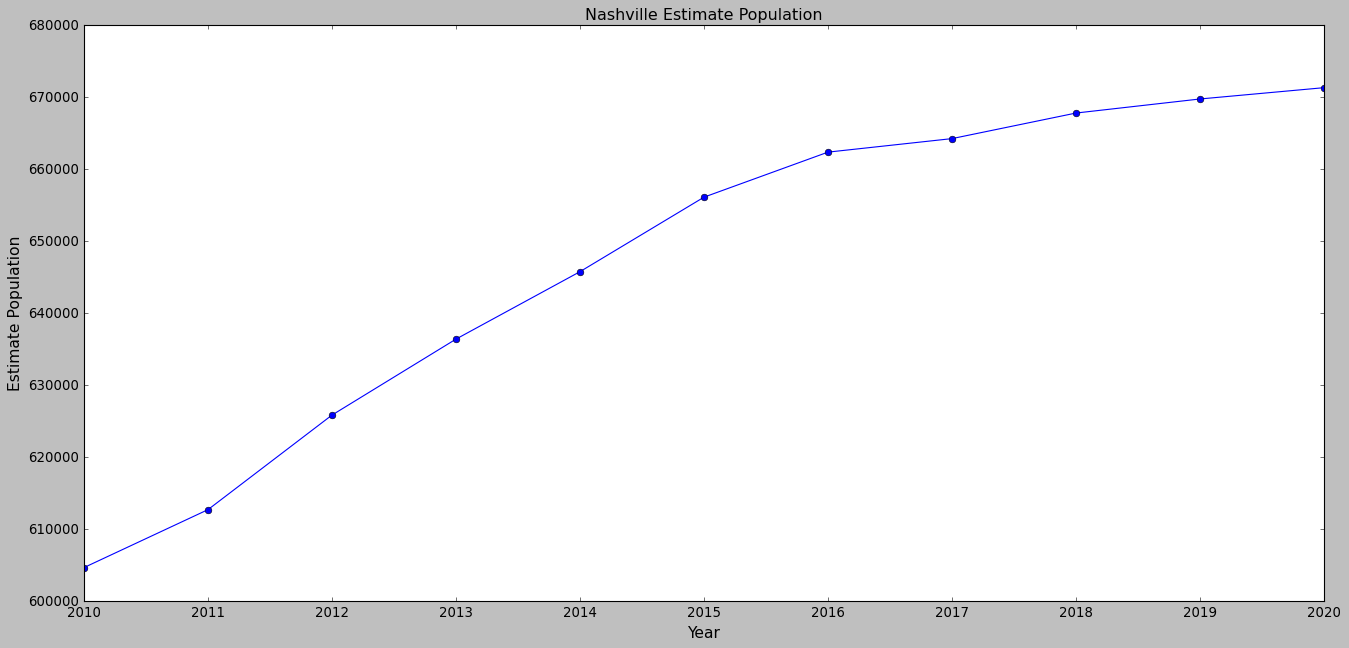

In [22]:
plt.style.use('classic')
plt.figure(figsize=(20, 9))

plt.plot(
    transpose['Year'],
    transpose['Estimated_Pop'],
    marker = 'o'
)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Estimate Population", fontsize=14)
plt.title('Nashville Estimate Population')

In [23]:
# Percent change over the 10 year period
(transpose['Estimated_Pop'][10] - transpose['Estimated_Pop'][0])/transpose['Estimated_Pop'][0] * 100

11.023180582293051


Lets assume that Nashville will grow at 11% every 10 years. We can calculate the population estimate for the next couple of decades. \
We can then take those numbers and see what cities are currently at those levels. 


In [32]:
# I'm going to hard code this because I'm a little stuck.

dict = {'Year':['2021','2022','2023','2024','2025','2026','2027','2028','2029','2030','2031','2032','2033','2034','2035','2036','2037','2038','2039','2040'],
        'Estimated_Pop':[678679,686145,693692,701323,709037,716837,724722,732694,740754,748902,757140,765468,773889,782401,791008,799709,808506,817399,826391,835481]
       }
  
df1 = pd.DataFrame(dict)
df1['Estimated_Pop'] = df1['Estimated_Pop'].astype(int)
df1.info()

  
forecast_pop = pd.concat([transpose, df1], ignore_index = True)
forecast_pop

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           20 non-null     object
 1   Estimated_Pop  20 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 368.0+ bytes


,Year,Estimated_Pop
0,2010,604644
1,2011,612689
2,2012,625824
3,2013,636375
4,2014,645741
5,2015,656089
6,2016,662344
7,2017,664220
8,2018,667772
9,2019,669725


<AxesSubplot:>

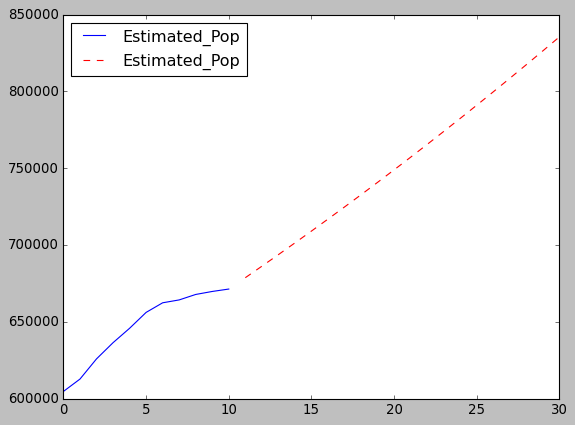

In [33]:
ax = forecast_pop.iloc[:11,:].plot(ls="-", color="b")
forecast_pop.iloc[11:,:].plot(ls="--", color="r", ax=ax)


In [25]:
# Let's find current similar cities as the forecasted 2030, 2040, 2050 pop of Nash. I will still use +-10% range.

upper_2030 = 745138*1.1
lower_2030 = 745138*0.9
nash_2030 = city_2020_pop[((city_2020_pop['POPESTIMATE2020'] <= upper_2030) & (city_2020_pop['POPESTIMATE2020'] >= lower_2030))]

upper_2040 = 827103*1.1
lower_2040 = 827103*0.9
nash_2040 = city_2020_pop[((city_2020_pop['POPESTIMATE2020'] <= upper_2040) & (city_2020_pop['POPESTIMATE2020'] >= lower_2040))]

upper_2050 = 918084*1.1
lower_2050 = 918084*0.9
nash_2050 = city_2020_pop[((city_2020_pop['POPESTIMATE2020'] <= upper_2050) & (city_2020_pop['POPESTIMATE2020'] >= lower_2050))]

In [26]:
nash_2030['CITY'] = nash_2030['CITY'].str.replace('city','')
nash_2030.loc[(nash_2030.CITY == 'Nashville-Davidson metropolitan government (balance)'),'CITY']='Nashville'
# nash_2030.to_csv(r'../data/census/nash_2030.csv', index = False)
nash_2030

<ipython-input-26-776a211337d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_2030['CITY'] = nash_2030['CITY'].str.replace('city','')
C:\Users\tye64\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,CITY,STATE,POPESTIMATE2020
3996,Denver,Colorado,735538
5034,Washington,District of Columbia,712816
28330,Boston,Massachusetts,691531
70455,Nashville,Tennessee,671295
71496,El Paso,Texas,681534
76172,Seattle,Washington,769714


In [27]:
nash_2040['CITY'] = nash_2040['CITY'].str.replace('city','')
nash_2040.loc[(nash_2040.CITY == 'Indianapolis (balance)'),'CITY']='Indianapolis'
# nash_2040.to_csv(r'../data/census/nash_2040.csv', index = False)
nash_2040

<ipython-input-27-f76af2ee27af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_2040['CITY'] = nash_2040['CITY'].str.replace('city','')
C:\Users\tye64\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,CITY,STATE,POPESTIMATE2020
3226,San Francisco,California,866606
15546,Indianapolis (balance),Indiana,877903
49715,Charlotte,North Carolina,900350
54071,Columbus,Ohio,903852
76172,Seattle,Washington,769714


In [28]:
nash_2050['CITY'] = nash_2050['CITY'].str.replace('city','')
nash_2050.loc[(nash_2050.CITY == 'Indianapolis (balance)'),'CITY']='Indianapolis'
# nash_2050.to_csv(r'../data/census/nash_2050.csv', index = False)
nash_2050

<ipython-input-28-1cb993d90939>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nash_2050['CITY'] = nash_2050['CITY'].str.replace('city','')
C:\Users\tye64\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,CITY,STATE,POPESTIMATE2020
3226,San Francisco,California,866606
5209,Jacksonville,Florida,920570
15546,Indianapolis (balance),Indiana,877903
49715,Charlotte,North Carolina,900350
54071,Columbus,Ohio,903852
71210,Austin,Texas,995484
71532,Fort Worth,Texas,927720


# Let's make some graphs to compare Nash to similar sized cities 

In [34]:
# Just a reminder on the similar sized cities table

similar_size_cities

,CITY,STATE,POPESTIMATE2020
3996,Denver,Colorado,735538
5034,Washington,District of Columbia,712816
25634,Louisville,Kentucky,618338
28330,Boston,Massachusetts,691531
28996,Detroit,Michigan,665369
43978,Las Vegas,Nevada,662368
59874,Oklahoma City,Oklahoma,662314
61026,Portland,Oregon,656751
70434,Memphis,Tennessee,649705
70455,Nashville,Tennessee,671295


In [48]:
# Lets take a look at their population history. Going to 'join' it back to OG table

similar_cities_years = similar_size_cities.merge(city_pop, how = 'left', on = ['CITY', 'STATE'])
similar_cities_years

,CITY,STATE,POPESTIMATE2020_x,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020_y
0,Denver,Colorado,735538,600158,599454,603012,620250,634965,649270,664540,683328,696273,704869,716340,725508,735538
1,Washington,District of Columbia,712816,601723,601767,605282,620290,635737,651559,663603,677014,687576,697079,704147,708253,712816
2,Louisville,Kentucky,618338,597337,595730,596518,600002,604389,610672,612890,615679,617838,620183,618997,618490,618338
3,Boston,Massachusetts,691531,617594,617779,621053,630620,643180,653312,663260,670982,680218,688239,692048,694661,691531
4,Detroit,Michigan,665369,713777,713956,711198,705202,700289,691986,682746,679562,677379,675031,673658,670442,665369
5,Las Vegas,Nevada,662368,583756,584500,584600,586682,593406,599739,608216,617820,626952,635746,644055,653963,662368
6,Oklahoma City,Oklahoma,662314,579999,580494,582560,591042,601040,612147,621673,632188,640010,642903,648241,655334,662314
7,Portland,Oregon,656751,583776,583810,585476,595610,604521,610254,620975,631945,643065,648176,651154,654378,656751
8,Memphis,Tennessee,649705,646889,651874,652349,655434,658961,657386,655299,654469,653026,651398,651700,650998,649705
9,Nashville,Tennessee,671295,601222,603465,604644,612689,625824,636375,645741,656089,662344,664220,667772,669725,671295


In [49]:
similar_cities_years = similar_cities_years.drop(columns = ['STATE','POPESTIMATE2020_x', 'ESTIMATESBASE2010', 'CENSUS2010POP', 'ESTIMATESBASE2010'])
similar_cities_years

,CITY,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020_y
0,Denver,603012,620250,634965,649270,664540,683328,696273,704869,716340,725508,735538
1,Washington,605282,620290,635737,651559,663603,677014,687576,697079,704147,708253,712816
2,Louisville,596518,600002,604389,610672,612890,615679,617838,620183,618997,618490,618338
3,Boston,621053,630620,643180,653312,663260,670982,680218,688239,692048,694661,691531
4,Detroit,711198,705202,700289,691986,682746,679562,677379,675031,673658,670442,665369
5,Las Vegas,584600,586682,593406,599739,608216,617820,626952,635746,644055,653963,662368
6,Oklahoma City,582560,591042,601040,612147,621673,632188,640010,642903,648241,655334,662314
7,Portland,585476,595610,604521,610254,620975,631945,643065,648176,651154,654378,656751
8,Memphis,652349,655434,658961,657386,655299,654469,653026,651398,651700,650998,649705
9,Nashville,604644,612689,625824,636375,645741,656089,662344,664220,667772,669725,671295


In [50]:
r = similar_cities_years.set_index('CITY').T.reset_index()
r

CITY,index,Denver,Washington,Louisville,Boston,Detroit,Las Vegas,Oklahoma City,Portland,Memphis,Nashville,El Paso
0,POPESTIMATE2010,603012,605282,596518,621053,711198,584600,582560,585476,652349,604644,650482
1,POPESTIMATE2011,620250,620290,600002,630620,705202,586682,591042,595610,655434,612689,664141
2,POPESTIMATE2012,634965,635737,604389,643180,700289,593406,601040,604521,658961,625824,674588
3,POPESTIMATE2013,649270,651559,610672,653312,691986,599739,612147,610254,657386,636375,674362
4,POPESTIMATE2014,664540,663603,612890,663260,682746,608216,621673,620975,655299,645741,676664
5,POPESTIMATE2015,683328,677014,615679,670982,679562,617820,632188,631945,654469,656089,675561
6,POPESTIMATE2016,696273,687576,617838,680218,677379,626952,640010,643065,653026,662344,679001
7,POPESTIMATE2017,704869,697079,620183,688239,675031,635746,642903,648176,651398,664220,679978
8,POPESTIMATE2018,716340,704147,618997,692048,673658,644055,648241,651154,651700,667772,678552
9,POPESTIMATE2019,725508,708253,618490,694661,670442,653963,655334,654378,650998,669725,680028


In [64]:
# Cleaning

r=r.rename(columns={"CITY": "index", 'index': "Year"})
r['Year'] = r['Year'].str.replace('POPESTIMATE','')
r['Year'] = r['Year'].str.replace('_y','')
similar_cities_year = r
similar_cities_year

CITY,Year,Denver,Washington,Louisville,Boston,Detroit,Las Vegas,Oklahoma City,Portland,Memphis,Nashville,El Paso
0,2010,603012,605282,596518,621053,711198,584600,582560,585476,652349,604644,650482
1,2011,620250,620290,600002,630620,705202,586682,591042,595610,655434,612689,664141
2,2012,634965,635737,604389,643180,700289,593406,601040,604521,658961,625824,674588
3,2013,649270,651559,610672,653312,691986,599739,612147,610254,657386,636375,674362
4,2014,664540,663603,612890,663260,682746,608216,621673,620975,655299,645741,676664
5,2015,683328,677014,615679,670982,679562,617820,632188,631945,654469,656089,675561
6,2016,696273,687576,617838,680218,677379,626952,640010,643065,653026,662344,679001
7,2017,704869,697079,620183,688239,675031,635746,642903,648176,651398,664220,679978
8,2018,716340,704147,618997,692048,673658,644055,648241,651154,651700,667772,678552
9,2019,725508,708253,618490,694661,670442,653963,655334,654378,650998,669725,680028


In [67]:
# Graph

plt.style.use('classic')
plt.figure(figsize=(20, 9))

similar_cities_year[["Denver", "Washington", "Louisville", "Boston",'Detroit','Las Vegas','Oklahoma City','Portland','Memphis','Nashville','El Paso']].plot(x="Year", kind="bar")

plt.xlabel("Year", fontsize=14)
plt.ylabel("Estimate Population", fontsize=14)
plt.title('Nashville and Similar Sized Cities')

KeyError: "['Oklahoma City', 'Denver', 'El Paso', 'Boston', 'Memphis', 'Las Vegas', 'Washington', 'Portland', 'Detroit'] not in index"

<Figure size 1600x720 with 0 Axes>